# 04-extract_tdml

This notebook extracts time delayed melody surface from the predominant melody of each audio recording. The feature was introduced in:

> Gulati S, Serrà J, Ganguli K K, Şentürk S, Serra X. Time-delayed melody surfaces for Rāga recognition. In Proceedings of the 17th International Society for Music Information Retrieval Conference (ISMIR 2016); 2016 Aug 7-11; New York City (NY). p. 751-7.


In [1]:
import mre


In [2]:
import numpy as np

In [3]:
def bhat(mtx1, mtx2):
    return -np.log(np.sum(np.sqrt(mtx1 * mtx2)))

# code ported from https://github.com/sankalpg/Library_PythonNew
EPS = np.finfo(np.float).resolution
def sym_kld(mtx1, mtx2):
    mtx1 = mtx1 + EPS
    mtx2 = mtx2 + EPS
    return mtx1 * np.log(mtx1/mtx2) + mtx2 * np.log(mtx2/mtx1)  

## Stop if pitch class distibution was run in the past

Extracting the feature may take a long time. It is better to check if there is already a run in advance.

In [ ]:
# run = mre.mlflow_common.get_run_by_name(
#     mre.data.PitchClassDistribution.EXPERIMENT_NAME,
#     mre.data.PitchClassDistribution.RUN_NAME)

# if run is not None:
#     raise ValueError(
#         "There is already a run for %s:%s. Overwriting is not "
#         "permitted. Please delete the run manually if you want "
#         "to extract the pitch class distribution again."
#         % (mre.data.PitchClassDistribution.RUN_NAME, run.run_id))


# Read predominant melody filepaths from mlflow


In [4]:
melody_paths = mre.data.PredominantMelodyMakam.from_mlflow()
display(melody_paths[:5])

['/data/artifacts/1/2608c404325846309549b68e5020bd17/artifacts/006536f8-bf54-4cc0-a510-5a52456d09f8.npy',
 '/data/artifacts/1/2608c404325846309549b68e5020bd17/artifacts/009309d2-c260-4808-8f1d-44a5ddc6bc5f.npy',
 '/data/artifacts/1/2608c404325846309549b68e5020bd17/artifacts/00a48b5f-a35a-436c-a7a0-4438130f4abf.npy',
 '/data/artifacts/1/2608c404325846309549b68e5020bd17/artifacts/00ab81ec-07f8-47ba-9610-47ad56393eb9.npy',
 '/data/artifacts/1/2608c404325846309549b68e5020bd17/artifacts/00be9a4b-b85f-4601-a6d5-9ce1f5b3f91c.npy']

# Read tonic annotations from mlflow

In [5]:
annotations = mre.data.Annotation.from_mlflow()
tonic_frequencies = annotations.data.set_index("mbid")["tonic"]
tonic_frequencies.head()


mbid
00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f    256.0
168f7c75-84fb-4316-99d7-acabadd3b2e6    115.2
24f549dd-3fa4-4e9b-a356-778fbbfd5cad    232.5
407bb0b4-f19b-42ab-8c0a-9f1263126951    233.5
443819eb-6092-420c-bd86-d946a0ad6555    219.6
Name: tonic, dtype: float64

# Extract TDMLs from normalized predominant melody features and log to mlflow


In [ ]:
# pcd = mre.data.TimeDelayedMelodySurface()
# pcd.transform(melody_paths, tonic_frequencies)
# pcd.log()


In [7]:
from pathlib import Pathth
mel_mbids = [Path(pp).stem for pp in melody_paths]
tonic_mbids = list(tonic_frequencies.index)

# Compute for one

In [419]:
makam_idx = annotations.data[annotations.data["makam"] == "Huseyni"].index

mbid = annotations.data.iloc[makam_idx[3]].mbid
mbid

'0eac190d-13c4-442f-bb13-cf734d3cbe88'

In [420]:
for path in melody_paths:
    if mbid in path:
        break
# path = melody_paths[50]
print(path)
mbid = Path(path).stem


/data/artifacts/1/2608c404325846309549b68e5020bd17/artifacts/0eac190d-13c4-442f-bb13-cf734d3cbe88.npy


In [421]:
ref_freq = tonic_frequencies.loc[mbid]
ref_freq

221.0

In [422]:
annotations.data.set_index("mbid").loc[mbid]["makam"]


'Huseyni'

## Prepare melody

In [423]:
melody = np.load(path)
print(melody.shape)


(54074, 3)


In [424]:
from tomato.converter import Converter

MIN_AUDIBLE_FREQ = 20.0
BIN_SIZE = 25.0  # same as pcd
NUM_CENTS_IN_OCTAVE = 1200

# convert to cent; changes silent/unpitched frames (<20Hz) to np.nan
melody_cent = Converter.hz_to_cent(melody[:, 1], ref_freq)

# discretize around 0 cents with a bin size of 25 cents
melody_discretized = np.round(melody_cent/BIN_SIZE)

# octave wrap
melody_wrapped = np.mod(melody_discretized, 1200/BIN_SIZE)


In [425]:
# compute number of samples for time delay index = 0.3 sec 
time_delay_index = 0.3

melody_tags = mre.data.PredominantMelodyMakam.get_tags()
hop_size_sec = int(melody_tags['hopSize']) / float(melody_tags['sampleRate'])
num_sample_delay_index = int(round(time_delay_index/hop_size_sec))
num_sample_delay_index


103

In [426]:
def get_delay_coordinates(input_melody, t: int, m: int=2):
    """
    This function extract phase space embedding given an input signal (inp), number of delay 
    coordinates (m), and delay per coordinates (t) in samples.
    """
    if not type(t) == int:
        raise ValueError("Provide delay per coordinate as an integer (samples)")

    t_delay = (m-1) * t
    n_samples = len(input_melody)
    out_array = np.zeros((n_samples - t_delay, m))
    for ii in range(m):
        out_array[:, ii] = input_melody[t_delay - (ii * t): n_samples - (ii * t)]

    return out_array



In [427]:
delay_coord = get_delay_coordinates(melody_wrapped, num_sample_delay_index)

# remove silent delay coordinates
delay_coord_non_silent = delay_coord[~np.isnan(delay_coord).any(axis=1)]

# convert to indices
delay_coord_idx = delay_coord_non_silent.astype(int)

In [428]:
cent_bins = np.arange(0, 1200, 25)
def get_2d_representation(delay_coordinates):
    tdml = np.zeros((len(cent_bins), len(cent_bins)))
    for dc in delay_coordinates:
        tdml[dc[0], dc[1]] += 1
    
    return tdml
    
tdml = get_2d_representation(delay_coord_idx)


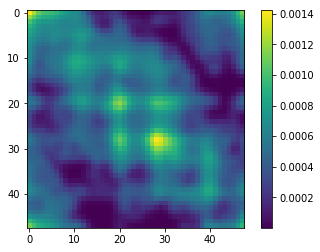

In [429]:
# compress
COMPRESSION_EXPONENT = 0.25
tdml_compressed = np.power(tdml, COMPRESSION_EXPONENT)

# smoothen
from scipy import ndimage
KERNEL_STD_IN_BINS = 1
tdml_smoothened = ndimage.gaussian_filter(tdml_compressed, KERNEL_STD_IN_BINS)

# normalize
tdml_norm = tdml_smoothened/tdml_smoothened.sum()

plt.imshow(tdml_norm)
plt.colorbar()

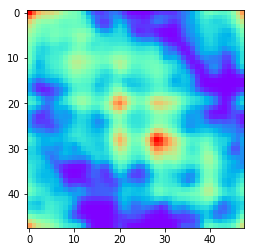

In [430]:
tdml_norm = tdml_smoothened/tdml_smoothened.max()

plt.imshow(tdml_norm, cmap="rainbow")